# Phân tích dữ liệu bằng Spark

In [ ]:
California Housing dataset

In [ ]:
Objective - Build a model to predict the housing price

# Tạo phiên làm việc cho Spark

In [1]:
# Import SparkSession
from pyspark.sql import SparkSession

# Build the SparkSession
spark = SparkSession.builder \
   .master("local") \
   .appName("Linear Regression Model") \
   .getOrCreate()
   
sc = spark.sparkContext

In [2]:
# Lấy dữ liệu data
rdd = sc.textFile('/CaliforniaHousing/cal_housing.data')

# Lấy thông tin các cột
header = sc.textFile('/CaliforniaHousing/cal_housing.domain')

# Tiền xử lý dữ liệu

In [3]:
header.collect()

['longitude: continuous.',
 'latitude: continuous.',
 'housingMedianAge: continuous. ',
 'totalRooms: continuous. ',
 'totalBedrooms: continuous. ',
 'population: continuous. ',
 'households: continuous. ',
 'medianIncome: continuous. ',
 'medianHouseValue: continuous. ']

In [4]:
rdd.take(2)

['-122.230000,37.880000,41.000000,880.000000,129.000000,322.000000,126.000000,8.325200,452600.000000',
 '-122.220000,37.860000,21.000000,7099.000000,1106.000000,2401.000000,1138.000000,8.301400,358500.000000']

In [5]:
# Split tách các dòng bằng đấu phẩy
rdd = rdd.map(lambda line: line.split(","))

# Kiểm tra lại bằng 2 dòng đầu tiên 
rdd.take(2)

[['-122.230000',
  '37.880000',
  '41.000000',
  '880.000000',
  '129.000000',
  '322.000000',
  '126.000000',
  '8.325200',
  '452600.000000'],
 ['-122.220000',
  '37.860000',
  '21.000000',
  '7099.000000',
  '1106.000000',
  '2401.000000',
  '1138.000000',
  '8.301400',
  '358500.000000']]

In [6]:
# Import module cần thiết để chuyển từ RDD sang DataFrame
from pyspark.sql import Row

# Map RDD thành DF
df = rdd.map(lambda line: Row(longitude=line[0], 
                              latitude=line[1], 
                              housingMedianAge=line[2],
                              totalRooms=line[3],
                              totalBedRooms=line[4],
                              population=line[5], 
                              households=line[6],
                              medianIncome=line[7],
                              medianHouseValue=line[8])).toDF()

In [7]:
df.show(5)

+-----------+----------------+---------+-----------+----------------+------------+-----------+-------------+-----------+
| households|housingMedianAge| latitude|  longitude|medianHouseValue|medianIncome| population|totalBedRooms| totalRooms|
+-----------+----------------+---------+-----------+----------------+------------+-----------+-------------+-----------+
| 126.000000|       41.000000|37.880000|-122.230000|   452600.000000|    8.325200| 322.000000|   129.000000| 880.000000|
|1138.000000|       21.000000|37.860000|-122.220000|   358500.000000|    8.301400|2401.000000|  1106.000000|7099.000000|
| 177.000000|       52.000000|37.850000|-122.240000|   352100.000000|    7.257400| 496.000000|   190.000000|1467.000000|
| 219.000000|       52.000000|37.850000|-122.250000|   341300.000000|    5.643100| 558.000000|   235.000000|1274.000000|
| 259.000000|       52.000000|37.850000|-122.250000|   342200.000000|    3.846200| 565.000000|   280.000000|1627.000000|
+-----------+----------------+--

In [8]:
# in ra kiểu dữ liệu của các cột
df.printSchema()

root
 |-- households: string (nullable = true)
 |-- housingMedianAge: string (nullable = true)
 |-- latitude: string (nullable = true)
 |-- longitude: string (nullable = true)
 |-- medianHouseValue: string (nullable = true)
 |-- medianIncome: string (nullable = true)
 |-- population: string (nullable = true)
 |-- totalBedRooms: string (nullable = true)
 |-- totalRooms: string (nullable = true)



In [9]:
# Import tất cả từ `sql.types`
from pyspark.sql.types import *

# Hàm chuyển đổi kiểu dữ liệu cho DataFrame
def convertColumn(df, names, newType):
  for name in names: 
     df = df.withColumn(name, df[name].cast(newType))
  return df 

# Lấy tất cả các cột của dataframe
columns = ['households', 'housingMedianAge', 'latitude', 'longitude', 'medianHouseValue', 'medianIncome', 'population', 'totalBedRooms', 'totalRooms']

# Conver df to `FloatType()`
df = convertColumn(df, columns, FloatType())

In [10]:
df.printSchema()

root
 |-- households: float (nullable = true)
 |-- housingMedianAge: float (nullable = true)
 |-- latitude: float (nullable = true)
 |-- longitude: float (nullable = true)
 |-- medianHouseValue: float (nullable = true)
 |-- medianIncome: float (nullable = true)
 |-- population: float (nullable = true)
 |-- totalBedRooms: float (nullable = true)
 |-- totalRooms: float (nullable = true)



In [11]:
df.select('population','totalBedRooms').show(10)

+----------+-------------+
|population|totalBedRooms|
+----------+-------------+
|     322.0|        129.0|
|    2401.0|       1106.0|
|     496.0|        190.0|
|     558.0|        235.0|
|     565.0|        280.0|
|     413.0|        213.0|
|    1094.0|        489.0|
|    1157.0|        687.0|
|    1206.0|        665.0|
|    1551.0|        707.0|
+----------+-------------+
only showing top 10 rows



# Thăm dò, khai thác thông tin từ dữ liệu

In [12]:
df.describe().show()

+-------+-----------------+------------------+-----------------+-------------------+------------------+------------------+------------------+-----------------+------------------+
|summary|       households|  housingMedianAge|         latitude|          longitude|  medianHouseValue|      medianIncome|        population|    totalBedRooms|        totalRooms|
+-------+-----------------+------------------+-----------------+-------------------+------------------+------------------+------------------+-----------------+------------------+
|  count|            20640|             20640|            20640|              20640|             20640|             20640|             20640|            20640|             20640|
|   mean|499.5396802325581|28.639486434108527|35.63186143109965|-119.56970444871473|206855.81690891474|3.8706710030346416|1425.4767441860465|537.8980135658915|2635.7630813953488|
| stddev|382.3297528316098| 12.58555761211163|2.135952380602968|  2.003531742932898|115395.61587441359|1.

In [13]:
type(df)

pyspark.sql.dataframe.DataFrame

In [14]:
# Do DataFrame của Spark không hỗ trợ Matplotlib nên ta chuyển sang DataFrame của Pandas
dfraw=df.toPandas()

In [15]:
type(dfraw)

pandas.core.frame.DataFrame

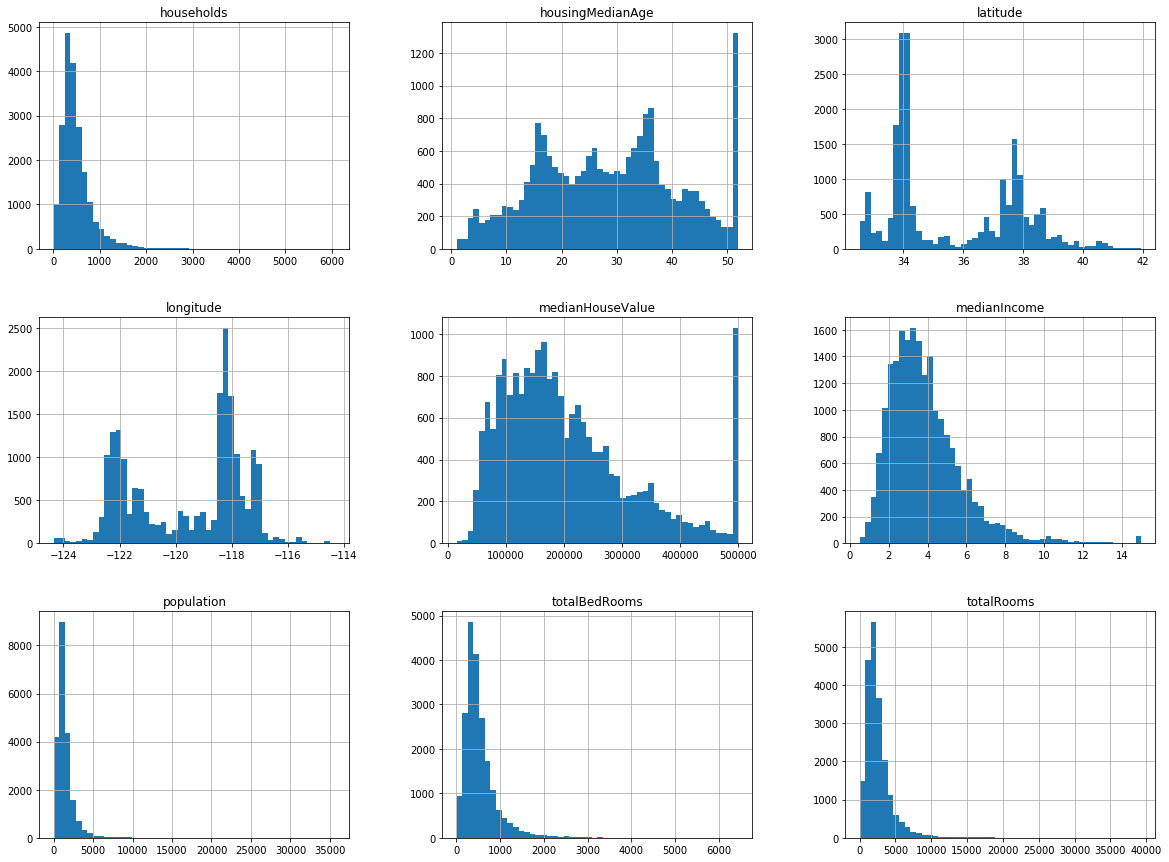

In [17]:
# Sử dụng matplotlib để in ra dữ liệu tổng thể
import matplotlib.pyplot as plt
dfraw.hist(bins=50, figsize=(20,15))
plt.show()

Nhận thấy các cột như HousingMedianAge, medianHouseValue, medianIncome tăng đột ngột ở giá trị cuối, có thể đây là giới hạn khi người làm dữ liệu đã cho vào, nên ta xóa các giá trị đó đi để mô hình học máy chính xác hơn 

In [18]:
df.groupBy("housingMedianAge").count().sort("housingMedianAge",ascending=False).describe().show()

+-------+------------------+-----------------+
|summary|  housingMedianAge|            count|
+-------+------------------+-----------------+
|  count|                52|               52|
|   mean|              26.5|396.9230769230769|
| stddev|15.154757228892407|236.6788877944161|
|    min|               1.0|                4|
|    max|              52.0|             1273|
+-------+------------------+-----------------+



In [19]:
 df = df.filter("housingMedianAge < 52")

In [20]:
df.groupBy("medianHouseValue").count().sort("medianHouseValue",ascending=False).describe().show()

+-------+------------------+------------------+
|summary|  medianHouseValue|             count|
+-------+------------------+------------------+
|  count|              3767|              3767|
|   mean|237751.31404300506| 5.141226440138041|
| stddev|120300.77273927572|14.057926473805535|
|    min|           14999.0|                 1|
|    max|          500001.0|               795|
+-------+------------------+------------------+



In [21]:
 df = df.filter("medianHouseValue < 500001")

In [22]:
df.groupBy("medianIncome").count().sort("medianIncome",ascending=True).describe().show()

+-------+------------------+------------------+
|summary|      medianIncome|             count|
+-------+------------------+------------------+
|  count|             11739|             11739|
|   mean| 3.903564126975025|1.5820768378907915|
| stddev|1.7688220159486174| 1.933633691854805|
|    min|            0.4999|                 1|
|    max|           15.0001|                46|
+-------+------------------+------------------+



In [23]:
df = df.filter("medianIncome < 15.0001")

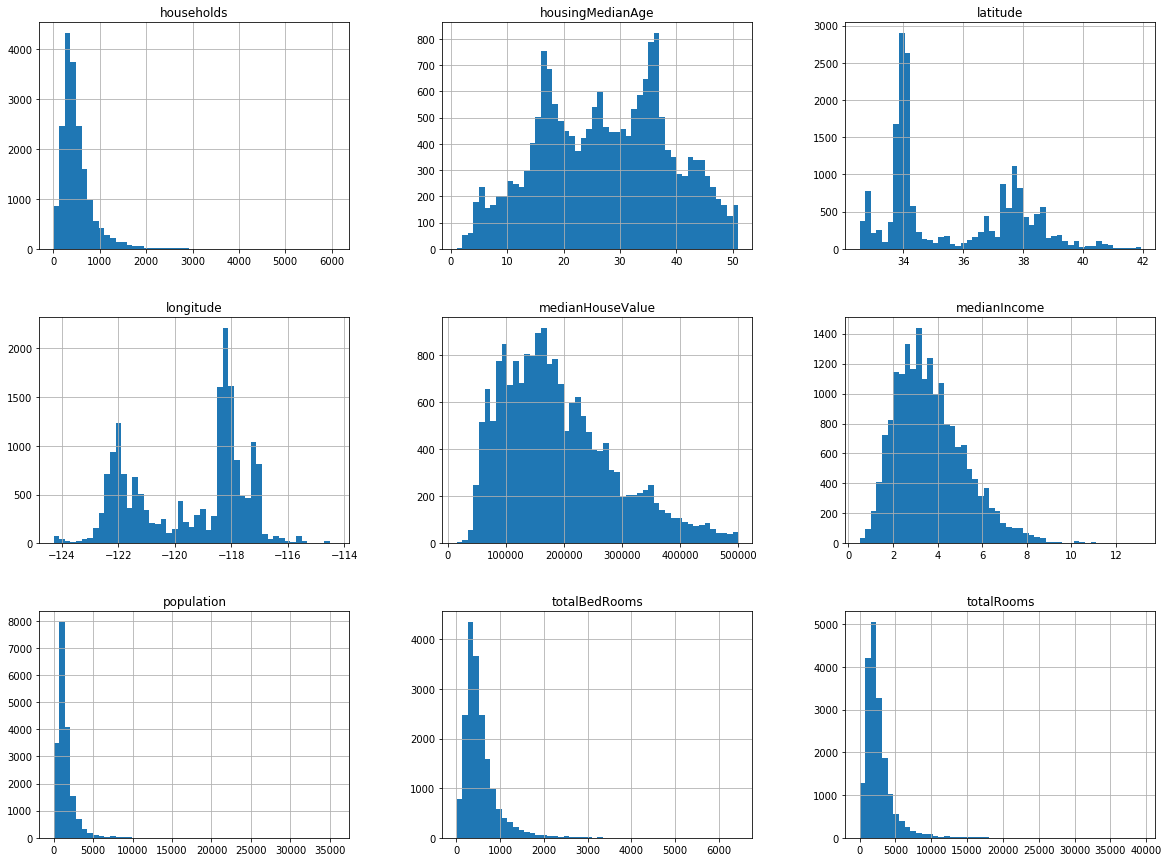

In [24]:
# Sử dụng matplotlib để in ra dữ liệu tổng thể
dfraw=df.toPandas()
import matplotlib.pyplot as plt
dfraw.hist(bins=50, figsize=(20,15))
plt.show()

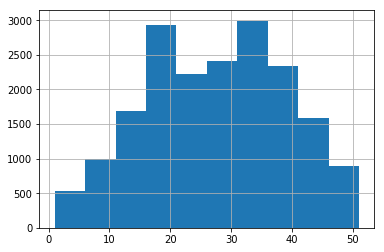

In [25]:
#In ra biểu đồ của housingMedianAge
dfraw['housingMedianAge'].hist(bins=10)

Tuổi ngôi nhà chủ yếu nằm trong khoảng 15 đến 45

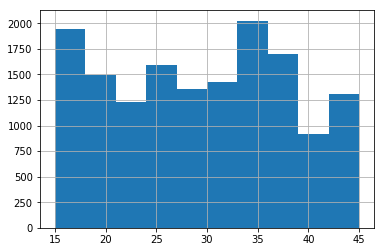

In [26]:
dfraw['housingMedianAge'].hist(bins=10,range=[15,45])

Tuổi ngôi nhà tập trung nhiều nhất là khoảng 32 đến 37 năm

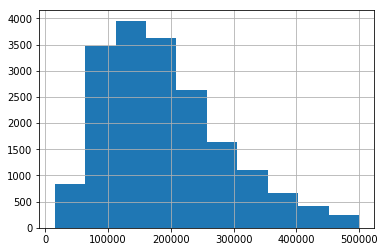

In [27]:
# In ra biểu đồ giá trị của các ngồi nhà
dfraw['medianHouseValue'].hist(bins=10)

Giá trị của ngôi nhà chủ yếu nằm trong khoàng 80000 đến 250000

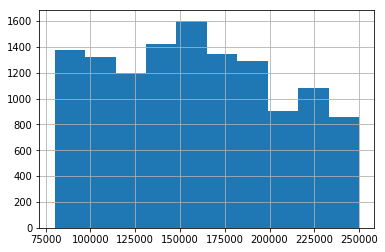

In [28]:
dfraw['medianHouseValue'].hist(bins=10, range=[80000,250000])

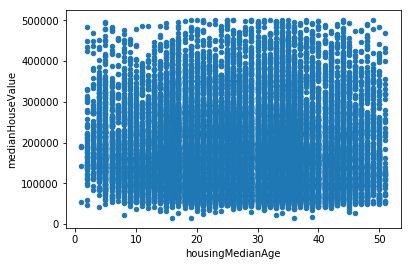

In [29]:
#in ra mối quan hệ của housingMedianAge và medianHouseValue
dfraw.plot.scatter('housingMedianAge','medianHouseValue')

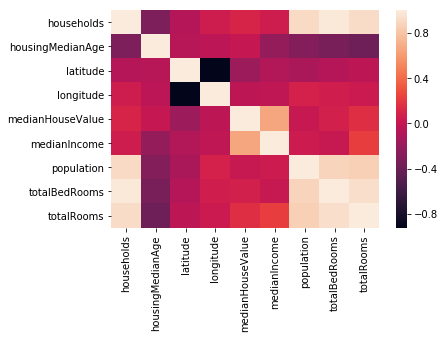

In [30]:
features=df.rdd.map(lambda row: row[0:])

from pyspark.ml.linalg import Vectors
from pyspark.ml.stat import Correlation
import pandas as pd
from pyspark.mllib.stat import Statistics


corr_mat=Statistics.corr(features, method="pearson")

pd.set_option('display.max_columns', 50)


col_names = [ 
              "households", 
              "housingMedianAge",
              "latitude",
              "longitude", 
              "medianHouseValue", 
              "medianIncome", 
              "population", 
              "totalBedRooms",
              "totalRooms"]
corr_df = pd.DataFrame(
                    corr_mat, 
                    index=col_names, 
                    columns=col_names)

import seaborn as sns
%matplotlib inline
sns.heatmap(corr_df, 
        xticklabels=corr_df.columns,
        yticklabels=corr_df.columns)

In [31]:
corr_matrix = dfraw.corr()
corr_matrix["medianHouseValue"].sort_values(ascending=False)

medianHouseValue    1.000000
medianIncome        0.661523
totalRooms          0.152887
households          0.100518
totalBedRooms       0.081073
population          0.021883
housingMedianAge    0.014984
longitude          -0.021911
latitude           -0.172343
Name: medianHouseValue, dtype: float64

# Kỹ thuật thêm 1 số đặc điểm

In [32]:
# Import `sql.functions` 
from pyspark.sql.functions import *

# Điều chỉnh giá trị của `medianHouseValue`
df = df.withColumn("medianHouseValue", col("medianHouseValue")/100000)

# Hiện thị 2 dòng đầu sau khi điều chỉnh
df.take(2)

[Row(households=126.0, housingMedianAge=41.0, latitude=37.880001068115234, longitude=-122.2300033569336, medianHouseValue=4.526, medianIncome=8.325200080871582, population=322.0, totalBedRooms=129.0, totalRooms=880.0),
 Row(households=1138.0, housingMedianAge=21.0, latitude=37.86000061035156, longitude=-122.22000122070312, medianHouseValue=3.585, medianIncome=8.301400184631348, population=2401.0, totalBedRooms=1106.0, totalRooms=7099.0)]

In [33]:
# Thêm cột mới bằng `totalRooms` / `households`
roomsPerHousehold = df.select(col("totalRooms")/col("households"))

# Thêm cột mới bằng `population` / `households`
populationPerHousehold = df.select(col("population")/col("households"))

# Thêm cột mới bằng `totalBedRooms` / `totalRooms`
bedroomsPerRoom = df.select(col("totalBedRooms")/col("totalRooms"))

# Add các cột mới vào df
df = df.withColumn("roomsPerHousehold", col("totalRooms")/col("households")) \
   .withColumn("populationPerHousehold", col("population")/col("households")) \
   .withColumn("bedroomsPerRoom", col("totalBedRooms")/col("totalRooms"))
   
# in kết quả
df.first()

Row(households=126.0, housingMedianAge=41.0, latitude=37.880001068115234, longitude=-122.2300033569336, medianHouseValue=4.526, medianIncome=8.325200080871582, population=322.0, totalBedRooms=129.0, totalRooms=880.0, roomsPerHousehold=6.984126984126984, populationPerHousehold=2.5555555555555554, bedroomsPerRoom=0.14659090909090908)

In [34]:
# Chọn các cột có khả năng đánh giá giá của ngôi nhà
df = df.select("medianHouseValue", 
              "totalBedRooms", 
              "population",
              "housingMedianAge",
              "households", 
              "medianIncome", 
              "roomsPerHousehold", 
            "populationPerHousehold", 
              "bedroomsPerRoom",
              "totalRooms")

In [35]:
# In ra 2 dòng đầu sau khi chọn các cột
df.take(2)

[Row(medianHouseValue=4.526, totalBedRooms=129.0, population=322.0, housingMedianAge=41.0, households=126.0, medianIncome=8.325200080871582, roomsPerHousehold=6.984126984126984, populationPerHousehold=2.5555555555555554, bedroomsPerRoom=0.14659090909090908, totalRooms=880.0),
 Row(medianHouseValue=3.585, totalBedRooms=1106.0, population=2401.0, housingMedianAge=21.0, households=1138.0, medianIncome=8.301400184631348, roomsPerHousehold=6.238137082601054, populationPerHousehold=2.109841827768014, bedroomsPerRoom=0.15579659106916466, totalRooms=7099.0)]

# Điều chỉnh độ giãn cách của thuộc tính (Features Scaling)

In [36]:
import pyspark.mllib
import pyspark.mllib.regression
from pyspark.mllib.regression import LabeledPoint
from pyspark.sql.functions import *

In [37]:
df.printSchema()

root
 |-- medianHouseValue: double (nullable = true)
 |-- totalBedRooms: float (nullable = true)
 |-- population: float (nullable = true)
 |-- housingMedianAge: float (nullable = true)
 |-- households: float (nullable = true)
 |-- medianIncome: float (nullable = true)
 |-- roomsPerHousehold: double (nullable = true)
 |-- populationPerHousehold: double (nullable = true)
 |-- bedroomsPerRoom: double (nullable = true)
 |-- totalRooms: float (nullable = true)



In [38]:
# Import `DenseVector`
from pyspark.ml.linalg import DenseVector

# Lấy label và features gắn vào `input_data` 
input_data = df.rdd.map(lambda x: (x[0], DenseVector(x[1:])))

# Tạo 1 dataframe mới chứa label và các features 
dfnew = spark.createDataFrame(input_data, ["label", "features"])

In [39]:
# Import `StandardScaler` 
from pyspark.ml.feature import StandardScaler

# Khởi tạo `standardScaler`
standardScaler = StandardScaler(inputCol="features", outputCol="features_scaled")

# Fit the DataFrame
scaler = standardScaler.fit(dfnew)

# Transform the data
scaled_df = scaler.transform(dfnew)

# In ra 2 dòng đầu tiên
scaled_df.take(2)

[Row(label=4.526, features=DenseVector([129.0, 322.0, 41.0, 126.0, 8.3252, 6.9841, 2.5556, 0.1466, 880.0]), features_scaled=DenseVector([0.3005, 0.2769, 3.5868, 0.3234, 5.3171, 2.9921, 0.2364, 2.6358, 0.3957])),
 Row(label=3.585, features=DenseVector([1106.0, 2401.0, 21.0, 1138.0, 8.3014, 6.2381, 2.1098, 0.1558, 7099.0]), features_scaled=DenseVector([2.5766, 2.0646, 1.8371, 2.9213, 5.3019, 2.6725, 0.1951, 2.8013, 3.1923]))]

In [40]:
# Tách dữ liệu thành train và test sets
train_data, test_data = scaled_df.randomSplit([.8,.2],seed=1234)

# Model Building - Linear Regression

In [41]:
# Import `LinearRegression`
from pyspark.ml.regression import LinearRegression

# Khởi tạo `lr`
lr = LinearRegression(labelCol="label", maxIter=10, regParam=0.3, elasticNetParam=0.8)
# Fit the data
linearModel = lr.fit(train_data)

In [42]:
# Tạo predictions
predicted = linearModel.transform(test_data)

# Chọn ra predict và lables
predictions = predicted.select("prediction").rdd.map(lambda x: x[0])
labels = predicted.select("label").rdd.map(lambda x: x[0])

# Ghép predict và label thành mảng
predictionAndLabel = predictions.zip(labels).collect()

# In ra 5 phần tử đầu tiên
predictionAndLabel[:5]

[(1.1412601082319624, 0.14999),
 (1.4094361836495775, 0.14999),
 (1.5141838846720497, 0.14999),
 (1.9721839598238238, 0.325),
 (1.5456821414212252, 0.375)]

In [43]:
# Hệ số của mô hình linearModel
linearModel.coefficients

DenseVector([0.0, 0.0, 0.0, 0.0, 0.2384, 0.0, 0.0, 0.0, 0.0])

# Model Evaluation - Linear Regression

In [44]:
# Lấy ra RMSE
linearModel.summary.rootMeanSquaredError

0.761986568816923

In [45]:
# Lấy ra R2
linearModel.summary.r2

0.3670505378912037

# RANDOM FORREST

In [46]:
from pyspark.ml import Pipeline
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.evaluation import RegressionEvaluator

In [47]:
#Chọn các cột có khả năng đánh giá giá của ngôi nhà
df4 = df.select("medianHouseValue",
               "totalBedRooms", 
              "population",
              "housingMedianAge",
              "households", 
              "medianIncome", 
              "roomsPerHousehold", 
            "populationPerHousehold", 
              "bedroomsPerRoom",)

In [48]:
df4.show()

+----------------+-------------+----------+----------------+----------+------------+------------------+----------------------+-------------------+
|medianHouseValue|totalBedRooms|population|housingMedianAge|households|medianIncome| roomsPerHousehold|populationPerHousehold|    bedroomsPerRoom|
+----------------+-------------+----------+----------------+----------+------------+------------------+----------------------+-------------------+
|           4.526|        129.0|     322.0|            41.0|     126.0|      8.3252| 6.984126984126984|    2.5555555555555554|0.14659090909090908|
|           3.585|       1106.0|    2401.0|            21.0|    1138.0|      8.3014| 6.238137082601054|     2.109841827768014|0.15579659106916466|
|           2.267|        665.0|    1206.0|            42.0|     595.0|      2.0804| 4.294117647058823|     2.026890756302521| 0.2602739726027397|
|             1.4|        283.0|     697.0|            50.0|     264.0|       2.125| 4.242424242424242|     2.64015151

# RANDOM FOREST REGRESSION

In [49]:
# In ra 5 hàng đầu tiên
df4.toPandas().head()

,medianHouseValue,totalBedRooms,population,housingMedianAge,households,medianIncome,roomsPerHousehold,populationPerHousehold,bedroomsPerRoom
0,4.526,129.0,322.0,41.0,126.0,8.3252,6.984127,2.555556,0.146591
1,3.585,1106.0,2401.0,21.0,1138.0,8.3014,6.238137,2.109842,0.155797
2,2.267,665.0,1206.0,42.0,595.0,2.0804,4.294118,2.026891,0.260274
3,1.400,283.0,697.0,50.0,264.0,2.1250,4.242424,2.640152,0.252679
4,1.587,455.0,990.0,50.0,419.0,1.9911,5.343675,2.362768,0.203216


In [50]:
# Lấy các features từ df4
features=df4.rdd.map(lambda row: row[1:])

In [51]:
from pyspark.mllib.util import MLUtils
from pyspark.mllib.linalg import Vectors
from pyspark.ml.linalg import Vectors
from pyspark.mllib.feature import StandardScaler

In [52]:
# Ta lại căn chỉnh lại tỷ lệ giữa các features
standardizer = StandardScaler()
model = standardizer.fit(features)
features_transform = model.transform(features)

In [53]:
features_transform.take(2)

[DenseVector([0.3005, 0.2769, 3.5868, 0.3234, 5.3171, 2.9921, 0.2364, 2.6358]),
 DenseVector([2.5766, 2.0646, 1.8371, 2.9213, 5.3019, 2.6725, 0.1951, 2.8013])]

In [54]:
# Lấy các label từ df4
labels=df4.rdd.map(lambda row: row[0])

In [55]:
# Ghép label và feature đã căn chỉnh tỷ lệ lại
transformedData=labels.zip(features_transform)
transformedData.take(2)

[(4.526,
  DenseVector([0.3005, 0.2769, 3.5868, 0.3234, 5.3171, 2.9921, 0.2364, 2.6358])),
 (3.585,
  DenseVector([2.5766, 2.0646, 1.8371, 2.9213, 5.3019, 2.6725, 0.1951, 2.8013]))]

In [56]:
# Tạo lại dữ liệu LabeledPoint
transformedData = transformedData.map(lambda row : LabeledPoint(row[0],row[1]))
transformedData.take(5)
type(transformedData)

pyspark.rdd.PipelinedRDD

In [57]:
# Tách dữ liệu thành train và test sets
trainingData, testingData = transformedData.randomSplit([.8,.2])

# Build the Model - Random Forest

In [58]:
# Import RamdomForest
from pyspark.mllib.tree import RandomForest, RandomForestModel
from pyspark.mllib.util import MLUtils
model = RandomForest.trainRegressor(trainingData, categoricalFeaturesInfo={},
                                        numTrees=3, featureSubsetStrategy="auto",
                                        impurity='variance', maxDepth=4, maxBins=32)

In [59]:
# Khởi tạo dự đoán predict
predictions = model.predict(testingData.map(lambda x: x.features))

In [60]:
# Ghép label và các predict lại thành mảng
labelsAndPredictions = testingData.map(lambda lp: lp.label).zip(predictions)

In [61]:
# In ra 2 kết quả đầu tiên
labelsAndPredictions.take(2)

[(1.049, 1.5315796261164607), (1.719, 1.9353146378681638)]

# Model Evaluation

In [62]:
# Tính RMSE
import math
testMSE = labelsAndPredictions.map(lambda lp: (lp[0] - lp[1]) * (lp[0] - lp[1])).sum() /\
    float(testingData.count())
TestRMSE = math.sqrt(testMSE)

In [63]:
# In RMSE của mô hình ramdom forest
print('Test Root Mean Squared Error = ' + str(TestRMSE))

Test Root Mean Squared Error = 0.7239577787210696


# Build the Model - Gradient Boosting Trees

In [64]:
# Import GradientBoostedTrees
from pyspark.mllib.tree import GradientBoostedTrees, GradientBoostedTreesModel
from pyspark.mllib.util import MLUtils

# Gradient Boosting Trees- With 3 iterations

In [65]:
# Khởi tạo model với 3 vòng lặp
model = GradientBoostedTrees.trainRegressor(trainingData,
                                            categoricalFeaturesInfo={}, numIterations=3)

In [66]:
# Khởi tạo dự đoán predict
predictions = model.predict(testingData.map(lambda x: x.features))
labelsAndPredictions = testingData.map(lambda lp: lp.label).zip(predictions)

In [67]:
# In ra 2 kết quả đầu tiên
labelsAndPredictions.take(2)

[(1.049, 1.136936698453511), (1.719, 1.6324059009794134)]

# Model Evaluation 

In [68]:
# Tính RMSE
testMSE = labelsAndPredictions.map(lambda lp: (lp[0] - lp[1]) * (lp[0] - lp[1])).sum() /\
    float(testingData.count())
TestRMSE = math.sqrt(testMSE)

In [69]:
# In ra RMSE và cây của mô hình
print('Test Root Mean Squared Error = ' + str(TestRMSE))
print('Learned regression GBT model:')
print(model.toDebugString())

Test Root Mean Squared Error = 0.6889557384091202
Learned regression GBT model:
TreeEnsembleModel regressor with 3 trees

  Tree 0:
    If (feature 4 <= 2.817585146725486)
     If (feature 4 <= 1.8370571662679316)
      If (feature 7 <= 4.880272880856413)
       Predict: 1.125292888165038
      Else (feature 7 > 4.880272880856413)
       Predict: 1.604129431009957
     Else (feature 4 > 1.8370571662679316)
      If (feature 6 <= 0.22347328821536513)
       Predict: 2.364351117519827
      Else (feature 6 > 0.22347328821536513)
       Predict: 1.6829905109489056
    Else (feature 4 > 2.817585146725486)
     If (feature 4 <= 3.7764622080247143)
      If (feature 6 <= 0.26005444800582855)
       Predict: 2.749725239616613
      Else (feature 6 > 0.26005444800582855)
       Predict: 2.1482217280813227
     Else (feature 4 > 3.7764622080247143)
      If (feature 4 <= 4.54929276895251)
       Predict: 3.096714437367305
      Else (feature 4 > 4.54929276895251)
       Predict: 3.7021241830065

# Gradient Boosting Trees- 100 iterations

In [70]:
# Tạo lại model với 100 vòng lặp
model = GradientBoostedTrees.trainRegressor(trainingData,
                                            categoricalFeaturesInfo={}, numIterations=100)

In [71]:
# Khởi tạo dự đoán predict
predictions = model.predict(testingData.map(lambda x: x.features))
labelsAndPredictions = testingData.map(lambda lp: lp.label).zip(predictions)

In [72]:
# Tính RMSE
testMSE = labelsAndPredictions.map(lambda lp: (lp[0] - lp[1]) * (lp[0] - lp[1])).sum() /\
    float(testingData.count())
TestRMSE = math.sqrt(testMSE)

In [73]:
# In ra RMSE
print('Test Root Mean Squared Error = ' + str(TestRMSE))

Test Root Mean Squared Error = 0.6014036944941135


# Tổng quan

Như vậy, ta đã load dữ liệu, tiền xử lý dữ liệu, thăm dò dữ liệu với các biểu đồ cụ thể, lọc các dữ liệu không chính xác so với thực tế, đánh giá mối tương quan giữa các features so với label, căn chỉnh lại tỷ lệ giữa các features, thêm 1 số features mới.
Cài đặt và chọn các Mô hình học máy để đánh giá giá của ngôi nhà.

In [ ]:
#Kết thúc phiên làm việc với SPARK
sc.stop()